https://github.com/mwaskom/seaborn/issues/3462

In [39]:
import warnings

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [ ]:
!pip install lightning

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import lightning.pytorch as pl

from torch.utils.data import TensorDataset, DataLoader

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder

In [21]:
class InsuranceDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size: int = 8):
        super().__init__()

        self.batch_size = batch_size
    
    def prepare_data(self):
        self.insurance_data = pd.read_csv("datasets/insurance.csv")
    
    def setup(self, stage = None):

        X = self.insurance_data.drop(columns = ["charges"])
        y = self.insurance_data["charges"]
        
        if stage == "fit" or stage is None:
            X_train, X_val, y_train, y_val = \
                train_test_split(X, y, test_size = 0.2, random_state = 123)
            
            categorical_features = ["sex", "smoker", "region"]
            
            categorical_transformer = OneHotEncoder(
                handle_unknown = "ignore", drop = "first", sparse_output = False
            )

            preprocessor = ColumnTransformer(
                transformers = [("cat_tr", categorical_transformer, categorical_features)],
                remainder = "passthrough"
            )
            
            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)

            y_train = y_train.to_numpy()
            y_val = y_val.to_numpy()
            
            ## Standard scaling features
            stdscaler = StandardScaler()
            X_train = stdscaler.fit_transform(X_train)
            X_val = stdscaler.transform(X_val)
            
            ## Min max scaling targets 
            min_max_scaler = MinMaxScaler()
            y_train = min_max_scaler.fit_transform(y_train.reshape(-1, 1))
            y_val = min_max_scaler.transform(y_val.reshape(-1, 1))
            
            ## Convert to tensors
            self.train_inputs = torch.from_numpy(X_train).float()
            self.train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()
            self.val_inputs = torch.from_numpy(X_val).float()
            self.val_targets = torch.from_numpy(y_val.reshape(-1, 1)).float()

    def train_dataloader(self):
        train_dataset = TensorDataset(
            self.train_inputs, self.train_targets
        )
        train_loader = DataLoader(
            dataset = train_dataset, 
            batch_size = self.batch_size, 
            shuffle = True,
            num_workers = 4
        )
        
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(
            self.val_inputs, self.val_targets
        )
        validation_loader = DataLoader(
            dataset = validation_dataset, 
            batch_size = self.batch_size,
            num_workers = 4
        )
        
        return validation_loader

Datamodule is instantiated

In [22]:
insurance_dm = InsuranceDataModule()

Both prepare_data and setup are invoked to check the preprocessed data

In [23]:
insurance_dm.prepare_data()
insurance_dm.setup()

Both training and validation dataloaders are checked. Note that batch size is set as 5 as default

In [24]:
train_dl = insurance_dm.train_dataloader()

next(iter(train_dl))

[tensor([[-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.6291,  0.4461, -0.8865],
         [ 0.9888,  2.0000, -0.5809,  1.6095, -0.5478,  0.8418,  2.0364,  0.7517],
         [-1.0113, -0.5000,  1.7213, -0.6213, -0.5478,  1.1253, -0.6091, -0.8865],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478,  0.1330,  0.5907,  0.7517],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.9303, -0.5617,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254,  0.2747,  0.6239,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254, -0.0797, -0.4396,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213, -0.5478,  0.4165,  1.5537,  1.5709]]),
 tensor([[0.1165],
         [0.7539],
         [0.1620],
         [0.0999],
         [0.0576],
         [0.1204],
         [0.0981],
         [0.1396]])]

In [25]:
val_dl = insurance_dm.val_dataloader()

next(iter(val_dl))

[tensor([[-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7000,  1.9999,  0.7517],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.5050,  1.1117, -0.0674],
         [-1.0113,  2.0000, -0.5809, -0.6213,  1.8254, -0.8594,  0.1254, -0.8865],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478, -0.2923, -1.0827, -0.0674],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478,  1.4797, -0.8152, -0.8865],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7709, -0.4130,  1.5709],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.8594, -1.9510,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254, -0.4341, -2.0183, -0.0674]]),
 tensor([[0.1412],
         [0.0577],
         [0.5485],
         [0.0651],
         [0.1793],
         [0.1559],
         [0.0603],
         [0.0593]])]

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

In [44]:
class LitRegressionModule(pl.LightningModule):
    
    def __init__(self, num_features, learning_rate = 0.01):
        super().__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()
        self.save_hyperparameters()
    
    def forward(self, inputs):

        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        
        return (x)
   
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        output = self.forward(x)
        
        loss_fn = nn.MSELoss(reduction = "mean")
        loss = loss_fn(output, y)
        
        self.log("train_loss", loss, prog_bar = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        
        output = self.forward(x)
        loss_fn = nn.MSELoss(reduction = "mean")
        loss = loss_fn(output, y)

        self.log(f"val_loss", loss, on_epoch = True, prog_bar = True)

    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch    
        
        return self(x)

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr = self.hparams.learning_rate)

We can generate output from Lightning Module in the same way as Pytorch Module

In [45]:
model = LitRegressionModule(num_features = 8) 

print(model)

LitRegressionModule(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


## TODO recording:

Please scroll and show the model output carefully

In [46]:
from pytorch_lightning.loggers import CSVLogger

insurance_dm = InsuranceDataModule() 

logger = CSVLogger("logs", name = "Pytorch_lightning_training")

trainer = pl.Trainer(max_epochs = 50, logger = logger)

trainer.fit(model, datamodule = insurance_dm) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type   | Params
-------------------------------------
0 | layer_1   | Linear | 144   
1 | layer_2   | Linear | 544   
2 | layer_3   | Linear | 528   
3 | layer_out | Linear | 17    
4 | relu      | ReLU   | 0     
-------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Epoch 0: 100%|█████████████████| 134/134 [00:10<00:00, 12.41it/s, v_num=4, train_loss=0.0123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 34.34it/s]
Epoch 1: 100%|█| 134/134 [00:05<00:00, 23.20it/s, v_num=4, train_loss=0.0131, val_loss=0.0375
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 71.69it/s]
Epoch 2: 100%|█| 134/134 [00:05<00:00, 24.22it/s, v_num=4, train_loss=0.0114, val_loss=0.0353
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  18%|█████▋                          | 6/34 [00:00<00:00, 45.29it/s]


Epoch 3: 100%|█| 134/134 [00:05<00:00, 25.35it/s, v_num=4, train_loss=0.033, val_loss=0.0325]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█| 134/134 [00:04<00:00, 27.11it/s, v_num=4, train_loss=0.020, val_loss=0.0296]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  44%|█████████████▋                 | 15/34 [00:00<00:00, 83.54it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 87.58it/s]
Epoch 5: 100%|█| 134/134 [00:05<00:00, 26.74it/s, v_num=4, train_loss=0.00745, val_loss=0.026
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 125.39it/s]
Epoch 6: 100%|█| 134/134 [00:04<00:00, 27.88it/s, v_num=4, train_loss=0.00876, val_loss=0.022
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  71%|█████████████████████▉         | 24/34 [00:00<00:00, 95.91it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 105.19it/s]
Epoch 7: 100%|█| 134/134 [00:04<00:00, 28.72it/s, v_num=4, train_loss=0.00749, val_loss=0.019
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|█| 134/134 [00:05<00:00, 24.73it/s, v_num=4, train_loss=0.012, val_loss=0.0164]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  97%|█████████████████████████████ | 33/34 [00:00<00:00, 103.08it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 103.98it/s]
Epoch 9: 100%|█| 134/134 [00:05<00:00, 25.23it/s, v_num=4, train_loss=0.00108, val_loss=0.014
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 122.77it/s]
Epoch 10: 100%|█| 134/134 [00:04<00:00, 28.62it/s, v_num=4, train_loss=0.0187, val_loss=0.012
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 93.20it/s]
Epoch 11: 100%|█| 134/134 [00:05<00:00, 25.74it/s, v_num=4, train_loss=0.00669, val_loss=0.01
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  15%|████▋                           | 5/34 [00:00<00:00, 47.16it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 94.87it/s]
Epoch 12: 100%|█| 134/134 [00:04<00:00, 26.82it/s, v_num=4, train_loss=0.00475, val_loss=0.01
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 105.19it/s]
Epoch 13: 100%|█| 134/134 [00:04<00:00, 27.23it/s, v_num=4, train_loss=0.00725, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  41%|████████████▊                  | 14/34 [00:00<00:00, 95.83it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 114.60it/s]
Epoch 14: 100%|█| 134/134 [00:05<00:00, 24.32it/s, v_num=4, train_loss=0.00744, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 97.27it/s]
Epoch 15: 100%|█| 134/134 [00:05<00:00, 24.80it/s, v_num=4, train_loss=0.00878, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  68%|████████████████████▎         | 23/34 [00:00<00:00, 117.01it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 120.99it/s]
Epoch 16: 100%|█| 134/134 [00:04<00:00, 27.03it/s, v_num=4, train_loss=0.0164, val_loss=0.008
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 106.01it/s]
Epoch 17: 100%|█| 134/134 [00:04<00:00, 28.16it/s, v_num=4, train_loss=0.00964, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  94%|█████████████████████████████▏ | 32/34 [00:00<00:00, 93.37it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 94.80it/s]
Epoch 18: 100%|█| 134/134 [00:04<00:00, 28.52it/s, v_num=4, train_loss=0.0242, val_loss=0.007
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 56.98it/s]
Epoch 19: 100%|█| 134/134 [00:05<00:00, 22.70it/s, v_num=4, train_loss=0.0126, val_loss=0.007
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 124.11it/s]
Epoch 20: 100%|█| 134/134 [00:05<00:00, 23.23it/s, v_num=4, train_loss=0.0269, val_loss=0.007
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███▊                            | 4/34 [00:00<00:00, 35.76it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 94.22it/s]
Epoch 21: 100%|█| 134/134 [00:04<00:00, 27.09it/s, v_num=4, train_loss=0.0306, val_loss=0.007
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 88.46it/s]
Epoch 22: 100%|█| 134/134 [00:04<00:00, 27.10it/s, v_num=4, train_loss=0.00314, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  38%|███████████▍                  | 13/34 [00:00<00:00, 100.98it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 117.22it/s]
Epoch 23: 100%|█| 134/134 [00:05<00:00, 26.32it/s, v_num=4, train_loss=0.0249, val_loss=0.007
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 37.95it/s]
Epoch 24: 100%|█| 134/134 [00:09<00:00, 14.76it/s, v_num=4, train_loss=0.0491, val_loss=0.007
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  65%|████████████████████           | 22/34 [00:00<00:00, 76.36it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 87.14it/s]
Epoch 25: 100%|█| 134/134 [00:05<00:00, 26.49it/s, v_num=4, train_loss=0.00213, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 75.59it/s]
Epoch 26: 100%|█| 134/134 [00:05<00:00, 24.18it/s, v_num=4, train_loss=0.00479, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  91%|████████████████████████████▎  | 31/34 [00:00<00:00, 84.57it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 87.30it/s]
Epoch 27: 100%|█| 134/134 [00:05<00:00, 26.03it/s, v_num=4, train_loss=0.00736, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 109.31it/s]
Epoch 28: 100%|█| 134/134 [00:05<00:00, 24.07it/s, v_num=4, train_loss=0.0131, val_loss=0.006
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 87.77it/s]
Epoch 29: 100%|█| 134/134 [00:05<00:00, 24.40it/s, v_num=4, train_loss=0.00826, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   9%|██▊                             | 3/34 [00:00<00:00, 43.78it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 98.10it/s]
Epoch 30: 100%|█| 134/134 [00:05<00:00, 26.66it/s, v_num=4, train_loss=0.00703, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 96.96it/s]
Epoch 31: 100%|█| 134/134 [00:07<00:00, 17.14it/s, v_num=4, train_loss=0.00195, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  35%|██████████▉                    | 12/34 [00:00<00:00, 41.77it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 63.64it/s]
Epoch 32: 100%|█| 134/134 [00:05<00:00, 24.72it/s, v_num=4, train_loss=0.00182, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 83.21it/s]
Epoch 33: 100%|█| 134/134 [00:06<00:00, 19.94it/s, v_num=4, train_loss=0.00192, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  62%|███████████████████▏           | 21/34 [00:00<00:00, 88.09it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 100.01it/s]
Epoch 34: 100%|█| 134/134 [00:05<00:00, 23.75it/s, v_num=4, train_loss=0.00555, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 115.28it/s]
Epoch 35: 100%|█| 134/134 [00:05<00:00, 25.08it/s, v_num=4, train_loss=0.0165, val_loss=0.006
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|███████████████████████████▎   | 30/34 [00:00<00:00, 59.07it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 61.95it/s]
Epoch 36: 100%|█| 134/134 [00:07<00:00, 16.95it/s, v_num=4, train_loss=0.00165, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 64.07it/s]
Epoch 37: 100%|█| 134/134 [00:10<00:00, 13.21it/s, v_num=4, train_loss=0.00747, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 67.68it/s]
Epoch 38: 100%|█| 134/134 [00:08<00:00, 15.60it/s, v_num=4, train_loss=0.00316, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   6%|█▉                              | 2/34 [00:00<00:00, 41.60it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 106.91it/s]
Epoch 39: 100%|█| 134/134 [00:05<00:00, 22.39it/s, v_num=4, train_loss=0.013, val_loss=0.0061
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 92.13it/s]
Epoch 40: 100%|█| 134/134 [00:06<00:00, 22.31it/s, v_num=4, train_loss=0.00142, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  32%|██████████                     | 11/34 [00:00<00:00, 72.97it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 91.20it/s]
Epoch 41: 100%|█| 134/134 [00:06<00:00, 19.55it/s, v_num=4, train_loss=0.00933, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 93.76it/s]
Epoch 42: 100%|█| 134/134 [00:06<00:00, 21.91it/s, v_num=4, train_loss=0.00329, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  59%|██████████████████▏            | 20/34 [00:00<00:00, 68.26it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 86.40it/s]
Epoch 43: 100%|█| 134/134 [00:06<00:00, 22.11it/s, v_num=4, train_loss=0.00244, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 98.37it/s]
Epoch 44: 100%|█| 134/134 [00:05<00:00, 22.39it/s, v_num=4, train_loss=0.00432, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  85%|██████████████████████████▍    | 29/34 [00:00<00:00, 75.59it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 78.32it/s]
Epoch 45: 100%|█| 134/134 [00:09<00:00, 14.54it/s, v_num=4, train_loss=0.0059, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 119.01it/s]
Epoch 46: 100%|█| 134/134 [00:06<00:00, 21.30it/s, v_num=4, train_loss=0.00633, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 120.17it/s]
Epoch 47: 100%|█| 134/134 [00:05<00:00, 22.83it/s, v_num=4, train_loss=0.00283, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   3%|▉                               | 1/34 [00:00<00:01, 32.24it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 77.25it/s]
Epoch 48: 100%|█| 134/134 [00:05<00:00, 24.03it/s, v_num=4, train_loss=0.0158, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 99.91it/s]
Epoch 49: 100%|█| 134/134 [00:05<00:00, 22.70it/s, v_num=4, train_loss=0.000326, val_loss=0.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  29%|█████████                      | 10/34 [00:00<00:00, 81.53it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 109.64it/s]
Epoch 50: 100%|█| 134/134 [00:06<00:00, 21.85it/s, v_num=4, train_loss=0.0479, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 108.48it/s]
Epoch 51: 100%|█| 134/134 [00:05<00:00, 25.54it/s, v_num=4, train_loss=0.00814, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  56%|█████████████████▎             | 19/34 [00:00<00:00, 38.65it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 51.02it/s]
Epoch 52: 100%|█| 134/134 [00:05<00:00, 23.57it/s, v_num=4, train_loss=0.00121, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 71.97it/s]
Epoch 53: 100%|█| 134/134 [00:06<00:00, 21.91it/s, v_num=4, train_loss=0.00693, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  82%|█████████████████████████▌     | 28/34 [00:00<00:00, 95.37it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 98.62it/s]
Epoch 54: 100%|█| 134/134 [00:05<00:00, 23.29it/s, v_num=4, train_loss=0.0146, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 89.31it/s]
Epoch 55: 100%|█| 134/134 [00:06<00:00, 21.31it/s, v_num=4, train_loss=0.00136, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 82.14it/s]
Epoch 56: 100%|█| 134/134 [00:05<00:00, 22.62it/s, v_num=4, train_loss=0.00418, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                        | 0/34 [00:00<?, ?it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 102.19it/s]
Epoch 57: 100%|█| 134/134 [00:05<00:00, 25.15it/s, v_num=4, train_loss=0.00815, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 68.19it/s]
Epoch 58: 100%|█| 134/134 [00:06<00:00, 21.43it/s, v_num=4, train_loss=0.00232, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  26%|████████▍                       | 9/34 [00:00<00:00, 39.61it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 58.15it/s]
Epoch 59: 100%|█| 134/134 [00:06<00:00, 21.67it/s, v_num=4, train_loss=0.00236, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 58.71it/s]
Epoch 60: 100%|█| 134/134 [00:07<00:00, 19.00it/s, v_num=4, train_loss=0.0154, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  53%|████████████████▍              | 18/34 [00:00<00:00, 27.41it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:01<00:00, 32.29it/s]
Epoch 61: 100%|█| 134/134 [00:07<00:00, 16.76it/s, v_num=4, train_loss=0.0106, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 94.99it/s]
Epoch 62: 100%|█| 134/134 [00:07<00:00, 18.48it/s, v_num=4, train_loss=0.00575, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  79%|███████████████████████▊      | 27/34 [00:00<00:00, 103.50it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 110.09it/s]
Epoch 63: 100%|█| 134/134 [00:05<00:00, 22.34it/s, v_num=4, train_loss=0.00149, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 120.86it/s]
Epoch 64: 100%|█| 134/134 [00:04<00:00, 26.87it/s, v_num=4, train_loss=0.000725, val_loss=0.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 100.82it/s]
Epoch 65: 100%|█| 134/134 [00:05<00:00, 24.02it/s, v_num=4, train_loss=0.0238, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                     | 0/34 [00:00<?, ?it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 102.70it/s]
Epoch 66: 100%|█| 134/134 [00:05<00:00, 22.75it/s, v_num=4, train_loss=0.00272, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 109.46it/s]
Epoch 67: 100%|█| 134/134 [00:05<00:00, 25.12it/s, v_num=4, train_loss=0.0159, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  24%|███████▎                       | 8/34 [00:00<00:00, 112.77it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 122.24it/s]
Epoch 68: 100%|█| 134/134 [00:05<00:00, 23.63it/s, v_num=4, train_loss=0.000405, val_loss=0.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 105.59it/s]
Epoch 69: 100%|█| 134/134 [00:05<00:00, 24.80it/s, v_num=4, train_loss=0.00329, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  50%|███████████████               | 17/34 [00:00<00:00, 102.21it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 96.44it/s]
Epoch 70: 100%|█| 134/134 [00:07<00:00, 19.02it/s, v_num=4, train_loss=0.016, val_loss=0.0053
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 92.24it/s]
Epoch 71: 100%|█| 134/134 [00:07<00:00, 18.44it/s, v_num=4, train_loss=0.00258, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  76%|███████████████████████▋       | 26/34 [00:00<00:00, 93.53it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 98.73it/s]
Epoch 72: 100%|█| 134/134 [00:05<00:00, 24.84it/s, v_num=4, train_loss=0.000376, val_loss=0.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 107.82it/s]
Epoch 73: 100%|█| 134/134 [00:05<00:00, 24.34it/s, v_num=4, train_loss=0.0105, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 95.16it/s]
Epoch 74: 100%|█| 134/134 [00:05<00:00, 23.74it/s, v_num=4, train_loss=0.00776, val_loss=0.00
Validation: 0it [00:00, ?it/s]


Validation DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 102.50it/s]
Epoch 75: 100%|█| 134/134 [00:05<00:00, 23.21it/s, v_num=4, train_loss=0.0162, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 59.71it/s]
Epoch 76: 100%|█| 134/134 [00:14<00:00,  9.54it/s, v_num=4, train_loss=0.0162, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  21%|██████▌                         | 7/34 [00:00<00:00, 41.93it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 52.25it/s]
Epoch 77: 100%|█| 134/134 [00:06<00:00, 19.85it/s, v_num=4, train_loss=0.00111, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 53.54it/s]
Epoch 78: 100%|█| 134/134 [00:12<00:00, 10.69it/s, v_num=4, train_loss=0.00215, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  47%|██████████████▌                | 16/34 [00:00<00:00, 51.14it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 48.30it/s]
Epoch 79: 100%|█| 134/134 [00:16<00:00,  8.34it/s, v_num=4, train_loss=0.00111, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 50.12it/s]
Epoch 80: 100%|█| 134/134 [00:15<00:00,  8.73it/s, v_num=4, train_loss=0.0065, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  74%|██████████████████████▊        | 25/34 [00:00<00:00, 86.13it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 87.33it/s]
Epoch 81: 100%|█| 134/134 [00:06<00:00, 20.58it/s, v_num=4, train_loss=0.00157, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 68.45it/s]
Epoch 82: 100%|█| 134/134 [00:06<00:00, 19.76it/s, v_num=4, train_loss=0.0127, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 80.76it/s]


Epoch 83: 100%|█| 134/134 [00:09<00:00, 13.48it/s, v_num=4, train_loss=0.000908, val_loss=0.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 60.33it/s]
Epoch 84: 100%|█| 134/134 [00:11<00:00, 12.02it/s, v_num=4, train_loss=0.00216, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 47.75it/s]
Epoch 85: 100%|█| 134/134 [00:11<00:00, 11.69it/s, v_num=4, train_loss=0.0133, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  18%|█████▋                          | 6/34 [00:00<00:00, 44.30it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 37.93it/s]
Epoch 86: 100%|█| 134/134 [00:13<00:00,  9.66it/s, v_num=4, train_loss=0.0129, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 38.51it/s]
Epoch 87: 100%|█| 134/134 [00:12<00:00, 10.32it/s, v_num=4, train_loss=0.00881, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  44%|█████████████▋                 | 15/34 [00:00<00:00, 40.42it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 54.21it/s]
Epoch 88: 100%|█| 134/134 [00:15<00:00,  8.54it/s, v_num=4, train_loss=0.000721, val_loss=0.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:01<00:00, 23.94it/s]
Epoch 89: 100%|█| 134/134 [00:14<00:00,  9.07it/s, v_num=4, train_loss=0.0022, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  71%|█████████████████████▉         | 24/34 [00:00<00:00, 38.03it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 39.58it/s]
Epoch 90: 100%|█| 134/134 [00:13<00:00,  9.59it/s, v_num=4, train_loss=0.0205, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 43.58it/s]
Epoch 91: 100%|█| 134/134 [00:12<00:00, 11.01it/s, v_num=4, train_loss=0.0135, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  97%|██████████████████████████████ | 33/34 [00:00<00:00, 44.30it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 44.62it/s]
Epoch 92: 100%|█| 134/134 [00:11<00:00, 12.11it/s, v_num=4, train_loss=0.0122, val_loss=0.005
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 53.68it/s]
Epoch 93: 100%|█| 134/134 [00:12<00:00, 10.42it/s, v_num=4, train_loss=0.00437, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 55.36it/s]
Epoch 94: 100%|█| 134/134 [00:13<00:00,  9.57it/s, v_num=4, train_loss=0.00172, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  15%|████▋                           | 5/34 [00:00<00:00, 29.90it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 39.10it/s]
Epoch 95: 100%|█| 134/134 [00:11<00:00, 11.34it/s, v_num=4, train_loss=0.00688, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:01<00:00, 28.50it/s]
Epoch 96: 100%|█| 134/134 [00:17<00:00,  7.67it/s, v_num=4, train_loss=0.0018, val_loss=0.004
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  41%|████████████▊                  | 14/34 [00:00<00:00, 53.49it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 54.73it/s]
Epoch 97: 100%|█| 134/134 [00:14<00:00,  9.57it/s, v_num=4, train_loss=0.00149, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 38.40it/s]
Epoch 98: 100%|█| 134/134 [00:13<00:00, 10.05it/s, v_num=4, train_loss=0.0239, val_loss=0.004
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  68%|████████████████████▉          | 23/34 [00:00<00:00, 89.67it/s]


Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 86.67it/s]
Epoch 99: 100%|█| 134/134 [00:09<00:00, 14.86it/s, v_num=4, train_loss=0.00967, val_loss=0.00
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████| 34/34 [00:00<00:00, 82.42it/s]
Epoch 99: 100%|█| 134/134 [00:17<00:00,  7.73it/s, v_num=4, train_loss=0.00967, val_loss=0.00

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|█| 134/134 [00:17<00:00,  7.71it/s, v_num=4, train_loss=0.00967, val_loss=0.00


Predictions obtained on validation dataloader.Note:We can predict on test dataloader if it is defined

In [55]:
predictions = trainer.predict(model = model, dataloaders = insurance_dm.val_dataloader())

predictions

Predicting DataLoader 0: 100%|██████████████████████████████| 34/34 [00:00<00:00, 105.33it/s]


[tensor([[0.1727],
         [0.1318],
         [0.5172],
         [0.1286],
         [0.1908],
         [0.1196],
         [0.0858],
         [0.0535]]),
 tensor([[0.0446],
         [0.1412],
         [0.1196],
         [0.1671],
         [0.2012],
         [0.4253],
         [0.1752],
         [0.3926]]),
 tensor([[0.1875],
         [0.0346],
         [0.6456],
         [0.7494],
         [0.5657],
         [0.7948],
         [0.0846],
         [0.1241]]),
 tensor([[0.0909],
         [0.1856],
         [0.2258],
         [0.0868],
         [0.2014],
         [0.0519],
         [0.0992],
         [0.2249]]),
 tensor([[0.0486],
         [0.0380],
         [0.0555],
         [0.2226],
         [0.2038],
         [0.0261],
         [0.1942],
         [0.1855]]),
 tensor([[0.1349],
         [0.1058],
         [0.0227],
         [0.5129],
         [0.1149],
         [0.0471],
         [0.1844],
         [0.1968]]),
 tensor([[0.2143],
         [0.1015],
         [0.1667],
         [0.1931],


Predictions are stacked

In [57]:
y_pred_stacked = torch.cat(predictions)

y_pred_stacked[:10]

tensor([[0.1727],
        [0.1318],
        [0.5172],
        [0.1286],
        [0.1908],
        [0.1196],
        [0.0858],
        [0.0535],
        [0.0446],
        [0.1412]])

Labels are stacked

In [58]:
labels = []

for data, label in insurance_dm.val_dataloader():
    labels.extend(label)

In [59]:
y_true = torch.stack(labels)

y_true[:10]

tensor([[0.1412],
        [0.0577],
        [0.5485],
        [0.0651],
        [0.1793],
        [0.1559],
        [0.0603],
        [0.0593],
        [0.0090],
        [0.1340]])

Performance are checked same as earlier

In [60]:
from torchmetrics.regression import R2Score
from torchmetrics.regression import MeanSquaredError

MSE = MeanSquaredError()
r2score = R2Score()

print("Mean Squared Error :", round(MSE(y_pred_stacked, y_true).item(), 3))
print("R^2 :",round(r2score(y_pred_stacked, y_true).item(), 3))

Mean Squared Error : 0.005
R^2 : 0.879


Logged CSV can be loaded from the 'Pytorch lightning training' (which is the experiment name defined in Logger folder) inside logs folder

In [61]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

metrics.head(10)

,train_loss,epoch,step,val_loss
0,0.038682,0,49,NaN
1,0.059337,0,99,NaN
2,NaN,0,133,0.037498
3,0.038038,1,149,NaN
4,0.074938,1,199,NaN
5,0.024370,1,249,NaN
6,NaN,1,267,0.035334
7,0.010010,2,299,NaN
8,0.015928,2,349,NaN
9,0.013598,2,399,NaN


In [62]:
metrics.tail(10)

,train_loss,epoch,step,val_loss
358,0.006782,97,13099,NaN
359,NaN,97,13131,0.004930
360,0.000580,98,13149,NaN
361,0.005027,98,13199,NaN
362,0.011316,98,13249,NaN
363,NaN,98,13265,0.004908
364,0.006759,99,13299,NaN
365,0.003744,99,13349,NaN
366,0.009668,99,13399,NaN
367,NaN,99,13399,0.004899


Obtaining visualisation for Loss vs epoch. Training loss is logged at every fifty steps and validation loss at the end of epoch

,train_loss,val_loss
epoch,,
0,0.038682,NaN
0,0.059337,NaN
0,NaN,0.037498
1,0.038038,NaN
1,0.074938,NaN
1,0.024370,NaN
1,NaN,0.035334
2,0.010010,NaN
2,0.015928,NaN


<Axes: xlabel='epoch'>

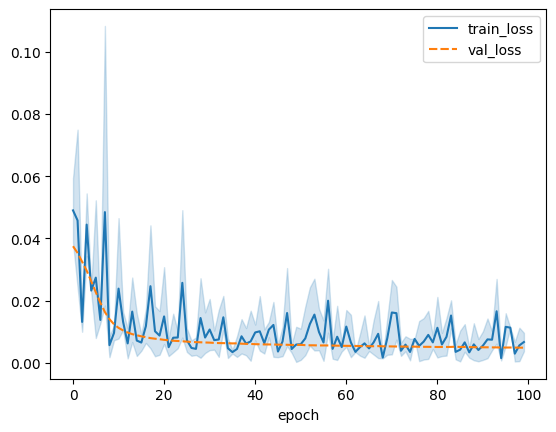

In [63]:
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis = 1, how = "all").head(10))

# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)